In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import torch
import random
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import os

In [2]:
!export CUDA_VISIBLE_DEVICES=3

In [3]:
!nvidia-smi

Sun Aug 15 13:05:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 33%   54C    P2   153W / 250W |   1573MiB / 11019MiB |     55%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1C:00.0 Off |                  N/A |
| 31%   51C    P2   155W / 250W |   1573MiB / 11019MiB |     56%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
print("checking time : " , time.time())
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

checking time :  1629047136.9031153
cuda:3


In [5]:
dirname = os.getcwd()

source_folder = os.path.join(dirname,'../data/imdb')
destination_folder =os.path.join(dirname,'../model')

In [6]:
## check source and desitnation folder
print(source_folder)
print(destination_folder)

/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../data/imdb
/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
# fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]
fields = [('text', text_field),('sentiment', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=True, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors


In [9]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [10]:

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def save_accuracy_log(save_path, train_accuracy_list, valid_accuracy_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_accuracy_list': train_accuracy_list,
                  'valid_accuracy_list': valid_accuracy_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Accuracy log saved to ==> {save_path}')
    
def load_accuracy_log(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Accuracy log loaded from <== {load_path}')
    
    return state_dict['train_accuracy_list'], state_dict['valid_accuracy_list'], state_dict['global_steps_list']

In [11]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
         max_encoder_num = None,
         random_elasticity = False):
    print(file_path + '/' +str(max_encoder_num)+ 'metrics.pt')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    
    val_acc = 0.0
    train_acc = 0.0
    valid_accuracy_list = []
    train_accuracy_list = []
    val_y_pred = []
    val_y_true = []
    train_y_pred = []
    train_y_true = []
    
    
    if not random_elasticity:
        if max_encoder_num is None:
            max_encoder_num = model.encoder.config.num_hidden_layers
        model.encoder.set_max_encoder_num(max_encoder_num)
        print("training the model with encoder number of " , max_encoder_num)


    # training loop
    model.train()
    
    for epoch in range(num_epochs):
        if random_elasticity:
            max_encoder_num = random.randint(5,12)
            model.encoder.set_max_encoder_num(max_encoder_num)
            print("training for epoch ", epoch," with encoder number of " , max_encoder_num)


        for (text,sentiment), _ in train_loader:
            text = text.type(torch.LongTensor)           
            text = text.to(device)
            sentiment = sentiment.type(torch.LongTensor)  
            sentiment = sentiment.to(device)
            output = model(text, sentiment)
            loss, output = output
            
            ##update the prediction and true list.
            train_y_pred.extend(torch.argmax(output, 1).tolist())
            train_y_true.extend(sentiment.tolist())
            train_acc +=accuracy_score(train_y_pred,train_y_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            
            # update running values
            running_loss += loss.item()
            global_step += 1
                    
            

            # evaluation step
            if global_step % eval_every == 0:
                
                
                model.eval()
                with torch.no_grad():

                        
                    # validation loop
                    for (text,sentiment), _ in valid_loader:
                        text = text.type(torch.LongTensor)           
                        text = text.to(device)
                        sentiment = sentiment.type(torch.LongTensor)  
                        sentiment = sentiment.to(device)
                        output = model(text, sentiment)
                        loss, output = output
                        
                        valid_running_loss += loss.item()
                        
                        ##update the prediction and true list.
                        val_y_pred.extend(torch.argmax(output, 1).tolist())
                        val_y_true.extend(sentiment.tolist())
                        val_acc += accuracy_score(val_y_pred,val_y_true)

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                
                average_train_accuracy = train_acc / eval_every
                average_valid_accuracy = val_acc / eval_every
                train_accuracy_list.append(average_train_accuracy)
                valid_accuracy_list.append(average_valid_accuracy)
                

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                train_acc = 0.0
                val_acc = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    if random_elasticity:
                        save_checkpoint(file_path + '/' +'random_elasticity_model.pt', model, best_valid_loss)
                        save_metrics(file_path +  'random_elasticity_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                    else:
                        save_checkpoint(file_path + '/' +str(max_encoder_num)+ 'model.pt', model, best_valid_loss)
                        save_metrics(file_path + '/' + str(max_encoder_num)+ 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    if random_elasticity:
        save_accuracy_log(file_path + '/' +'random_elasticity_acc_log.pt', train_accuracy_list, valid_accuracy_list, global_steps_list)
        save_metrics(file_path +  'random_elasticity_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                    
    save_metrics(file_path + '/' +str(max_encoder_num)+ 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    save_accuracy_log(file_path + '/' +str(max_encoder_num)+ 'acc_log.pt', train_accuracy_list, valid_accuracy_list, global_steps_list)

    print('Finished Training!')

In [12]:
# Evaluation Function

def evaluate(model, test_loader,max_encoder_num=None ):
    y_pred = []
    y_true = []
    
    if max_encoder_num:
        model.encoder.set_max_encoder_num(max_encoder_num)
    else:
        max_encoder_num = model.encoder.config.num_hidden_layers
        model.encoder.set_max_encoder_num(model.encoder.config.num_hidden_layers)
    
    print("evaluating with max encoder number of ", max_encoder_num)
    model.eval()
    with torch.no_grad():
        for (text,sentiment), _ in test_loader:
                text = text.type(torch.LongTensor)           
                text = text.to(device)
                sentiment = sentiment.type(torch.LongTensor)  
                sentiment = sentiment.to(device)
                output = model(text, sentiment)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(sentiment.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NEG', 'POS'])
    ax.yaxis.set_ticklabels(['NEG', 'POS'])
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_pred,y_true)

## Train BERT with layers 5 - 12

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9metrics.pt
changing encoder number :  12  =>  9
training the model with encoder number of  9
Epoch [1/5], Step [625/6250], Train Loss: 0.3591, Valid Loss: 0.3758
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9metrics.pt
Epoch [1/5], Step [1250/6250], Train Loss: 0.4043, Valid Loss: 0.3458
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9metrics.pt
Epoch [2/5], Step [1875/6250], Train Loss: 0.1599, Valid Loss: 0.4415
Epoch [2/5], Step [2500/6250], Train Loss: 0.2572, Valid Loss: 0.3420
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9metrics.pt

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 9 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/9model.pt
changing encoder number :  12  =>  9
evaluating with max encoder number of  9
Classification Report:
              precision    recall  f1-score   support

           1     0.8966    0.8002    0.8456     12500
           0     0.8196    0.9077    0.8614     12500

    accuracy                         0.8539     25000
   macro avg     0.8581    0.8539    0.8535     25000
weighted avg     0.8581    0.8539    0.8535     25000



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10metrics.pt
changing encoder number :  12  =>  10
training the model with encoder number of  10
Epoch [1/5], Step [625/6250], Train Loss: 0.3607, Valid Loss: 0.3874
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10metrics.pt
Epoch [1/5], Step [1250/6250], Train Loss: 0.3971, Valid Loss: 0.3445
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10metrics.pt
Epoch [2/5], Step [1875/6250], Train Loss: 0.1629, Valid Loss: 0.3975
Epoch [2/5], Step [2500/6250], Train Loss: 0.2485, Valid Loss: 0.3390
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10m

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 10 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/10model.pt
changing encoder number :  12  =>  10
evaluating with max encoder number of  10
Classification Report:
              precision    recall  f1-score   support

           1     0.9167    0.7665    0.8349     12500
           0     0.7994    0.9303    0.8599     12500

    accuracy                         0.8484     25000
   macro avg     0.8580    0.8484    0.8474     25000
weighted avg     0.8580    0.8484    0.8474     25000



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11metrics.pt
changing encoder number :  12  =>  11
training the model with encoder number of  11
Epoch [1/5], Step [625/6250], Train Loss: 0.3271, Valid Loss: 0.3991
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11metrics.pt
Epoch [1/5], Step [1250/6250], Train Loss: 0.3944, Valid Loss: 0.3220
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11metrics.pt
Epoch [2/5], Step [1875/6250], Train Loss: 0.1515, Valid Loss: 0.4018
Epoch [2/5], Step [2500/6250], Train Loss: 0.2551, Valid Loss: 0.3203
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11m

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 11 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/11model.pt
changing encoder number :  12  =>  11
evaluating with max encoder number of  11
Classification Report:
              precision    recall  f1-score   support

           1     0.8973    0.8055    0.8490     12500
           0     0.8236    0.9078    0.8637     12500

    accuracy                         0.8567     25000
   macro avg     0.8605    0.8567    0.8563     25000
weighted avg     0.8605    0.8567    0.8563     25000



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/12metrics.pt
changing encoder number :  12  =>  12
training the model with encoder number of  12
Epoch [1/5], Step [625/6250], Train Loss: 0.3482, Valid Loss: 0.3467
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/12metrics.pt
Epoch [1/5], Step [1250/6250], Train Loss: 0.3923, Valid Loss: 0.3513
Epoch [2/5], Step [1875/6250], Train Loss: 0.1594, Valid Loss: 0.4179
Epoch [2/5], Step [2500/6250], Train Loss: 0.2437, Valid Loss: 0.3488
Epoch [3/5], Step [3125/6250], Train Loss: 0.0807, Valid Loss: 0.5636
Epoch [3/5], Step [3750/6250], Train Loss: 0.1402, Valid Loss: 0.5340
Epoch [4/5], Step [4375/6250], Train Loss: 0.0583, Valid Loss: 0.5249
Epoch [4/5], Step [5000/6250], Train Loss: 0.0818, Valid Loss: 0.5152
Epoch [5/5], Step [5625/6250], Train Loss: 0.0322, Valid Loss: 0.5689
Epoch [5/5], Step [6

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 12 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/12model.pt
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.7961    0.9384    0.8614     12500
           0     0.9250    0.7596    0.8342     12500

    accuracy                         0.8490     25000
   macro avg     0.8605    0.8490    0.8478     25000
weighted avg     0.8605    0.8490    0.8478     25000

{9: 0.85392, 10: 0.8484, 11: 0.85668, 12: 0.849}


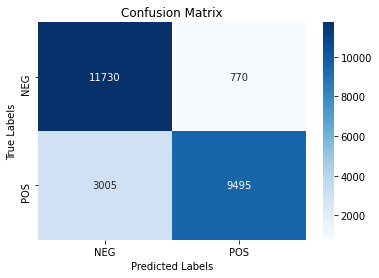

In [14]:
acc_dict = {}
for i in range(9,13):
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    train(model=model, optimizer=optimizer, num_epochs=5,max_encoder_num=i)
    best_model = BERT().to(device)
    print("loading model trained with " + str(i) + " number of layers")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)
    acc = evaluate(best_model, test_iter, max_encoder_num=i)
    acc_dict[i] = acc
print(acc_dict)


## Train Plain BERT base model

In [23]:
model = BERT().to(device)
model.encoder.config

initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [29]:
## Train Plain BERT base model -> 8 Epochs, using 12 encoder layers
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer, num_epochs=5)

/home/ilee300/workspace/nlp_ofa/notebooks/../model/Nonemetrics.pt
changing encoder number :  12  =>  12
training the model with encoder number of  12
Epoch [1/8], Step [625/10000], Train Loss: 0.2726, Valid Loss: 0.3753
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
Epoch [1/8], Step [1250/10000], Train Loss: 0.3955, Valid Loss: 0.3486
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
Epoch [2/8], Step [1875/10000], Train Loss: 0.1538, Valid Loss: 0.4097
Epoch [2/8], Step [2500/10000], Train Loss: 0.2558, Valid Loss: 0.3479
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
Epoch [3/8], Step [3125/10000], Train Loss: 0.0800, Valid Loss: 0.4570
Epoc

initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.9214    0.7457    0.8243     12500
           0     0.7864    0.9364    0.8549     12500

    accuracy                         0.8410     25000
   macro avg     0.8539    0.8410    0.8396     25000
weighted avg     0.8539    0.8410    0.8396     25000



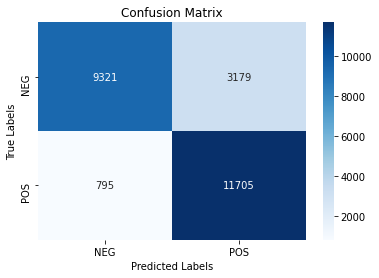

In [30]:
# Evaluate the best model
best_model = BERT().to(device)
load_checkpoint(destination_folder +"/"+ str(12)+ 'model.pt', best_model)
acc = evaluate(best_model, test_iter)


Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt


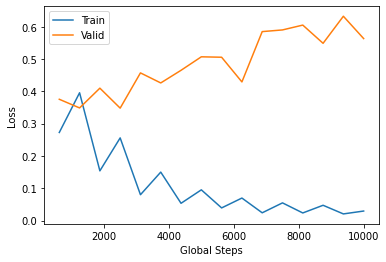

In [31]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder +"/"+  '12metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/12acc_log.pt


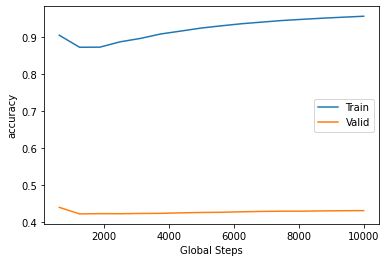

In [34]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder +"/"+  '12acc_log.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('accuracy')
plt.legend()
plt.show() 

In [ ]:
train_accuracy_list, valid_accuracy_list, global_steps_list = load_accuracy_log(destination_folder +"/"+  '12acc_log.pt')
plt.plot(global_steps_list, train_accuracy_list, label='Train')
plt.plot(global_steps_list, valid_accuracy_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show() 


### Comments

Seems like the best accuracy is achieved when the model is trained for just 2 epochs.

### Evaluate on different number of layers

In [42]:
import numpy as np
array = np.zeros((8,))

In [ ]:

## try different subnets and compare their accuracy
## Using the plain BERT base model trained using all 12 layers
## Evaluating using the first 5~12 layers
for i in range(5,13):
    #evaluating model with i layers
    print("accuracy when using ",i," layers")
    acc = evaluate(best_model, test_iter, max_encoder_num=i)
    array[i-5] = acc
    print(acc)




## Train and evaluate using 5 ~ 12 layers. No progressive shrinking. Each Training Independent of one another

In [43]:
array = np.zeros((8,8))

In [ ]:

## Train and evaluate using 5 ~ 12 layers. No progressive shrinking. Each Training Independent of one another
for i in range(5,12):
    ## create a new model
    model = BERT().to(device)
    print("\n\n****starting with layer number of ",i,"****")
    ## Train using the first i layers
    train(model=model, optimizer=optimizer, max_encoder_num=i)
    
    ## Evaluate the trained model
    best_model = BERT().to(device)
    print("loading model trained with " + str(i) + " number of layers")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)
    
    ## Getting the Evaluation using the first 5 ~ 12 layers
    for j in range(5,13):
        acc = evaluate(best_model, test_iter, max_encoder_num=j)
        array[i-5][j-5] = acc
        print("accuracy when using ", j, " layers : ", acc)
    print("results of the model trained using ",i," layers ")
    for j in range(5,13):
        print(j, " -> ", array[i-5][j-5])

## Progressive Shrinking

In [38]:
## Train using progressive shrinking
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

for i in range(12,4,-1):
    print("\n\n****starting with layer number of ",i,"****")
    ##Each layer trained for 2 epochs. -> try 1 epoch for each...
    train(model=model, optimizer=optimizer, max_encoder_num=i,num_epochs = 1)
    
    

initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at



****starting with layer number of  12 ****
/home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
changing encoder number :  12  =>  12
training the model with encoder number of  12
Epoch [1/1], Step [625/1250], Train Loss: 0.3192, Valid Loss: 0.3389
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
Epoch [1/1], Step [1250/1250], Train Loss: 0.3954, Valid Loss: 0.3453
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12acc_log.pt
Finished Training!


****starting with layer number of  11 ****
/home/ilee300/workspace/nlp_ofa/notebooks/../model/11metrics.pt
changing encoder number :  12  =>  11
training the model with encoder number of  11
Epoch [1/1], Step [625/1250], Train Loss: 0.1629, Valid Loss: 0.3998
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebo

initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 5 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/5model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.8677    0.7515    0.8055     12500
           0     0.7809    0.8854    0.8299     12500

    accuracy                         0.8185     25000
   macro avg     0.8243    0.8185    0.8177     25000
weighted avg     0.8243    0.8185    0.8177     25000

accuracy when using  5  layers :  0.81848
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.8697    0.7802    0.8226     12500
           0     0.8007    0.8831    0.8399     12500

    accuracy                         0.8317     25000
   macro avg     0.8352    0.8317    0.8312     25000
weighted avg     0.8352    0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 6 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/6model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.8904    0.3002    0.4490     12500
           0     0.5791    0.9630    0.7233     12500

    accuracy                         0.6316     25000
   macro avg     0.7348    0.6316    0.5861     25000
weighted avg     0.7348    0.6316    0.5861     25000

accuracy when using  5  layers :  0.6316
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.9028    0.7038    0.7910     12500
           0     0.7573    0.9242    0.8325     12500

    accuracy                         0.8140     25000
   macro avg     0.8300    0.8140    0.8117     25000
weighted avg     0.8300    0.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 7 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/7model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.9154    0.2276    0.3646     12500
           0     0.5590    0.9790    0.7116     12500

    accuracy                         0.6033     25000
   macro avg     0.7372    0.6033    0.5381     25000
weighted avg     0.7372    0.6033    0.5381     25000

accuracy when using  5  layers :  0.60328
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.8725    0.6865    0.7684     12500
           0     0.7416    0.8997    0.8130     12500

    accuracy                         0.7931     25000
   macro avg     0.8070    0.7931    0.7907     25000
weighted avg     0.8070    0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 8 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/8model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.6939    0.8798    0.7758     12500
           0     0.8358    0.6118    0.7065     12500

    accuracy                         0.7458     25000
   macro avg     0.7648    0.7458    0.7412     25000
weighted avg     0.7648    0.7458    0.7412     25000

accuracy when using  5  layers :  0.7458
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.6392    0.9537    0.7654     12500
           0     0.9088    0.4618    0.6124     12500

    accuracy                         0.7077     25000
   macro avg     0.7740    0.7077    0.6889     25000
weighted avg     0.7740    0.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 9 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/9model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.8950    0.2563    0.3985     12500
           0     0.5660    0.9699    0.7149     12500

    accuracy                         0.6131     25000
   macro avg     0.7305    0.6131    0.5567     25000
weighted avg     0.7305    0.6131    0.5567     25000

accuracy when using  5  layers :  0.61312
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.9159    0.4401    0.5945     12500
           0     0.6315    0.9596    0.7617     12500

    accuracy                         0.6998     25000
   macro avg     0.7737    0.6998    0.6781     25000
weighted avg     0.7737    0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 10 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/10model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5256    0.9518    0.6772     12500
           0     0.7451    0.1408    0.2368     12500

    accuracy                         0.5463     25000
   macro avg     0.6354    0.5463    0.4570     25000
weighted avg     0.6354    0.5463    0.4570     25000

accuracy when using  5  layers :  0.54632
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.5860    0.9648    0.7291     12500
           0     0.9005    0.3184    0.4704     12500

    accuracy                         0.6416     25000
   macro avg     0.7432    0.6416    0.5998     25000
weighted avg     0.7432   

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 11 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/11model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5736    0.9258    0.7083     12500
           0     0.8078    0.3117    0.4498     12500

    accuracy                         0.6188     25000
   macro avg     0.6907    0.6188    0.5791     25000
weighted avg     0.6907    0.6188    0.5791     25000

accuracy when using  5  layers :  0.61876
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.6458    0.8952    0.7503     12500
           0     0.8292    0.5090    0.6308     12500

    accuracy                         0.7021     25000
   macro avg     0.7375    0.7021    0.6905     25000
weighted avg     0.7375   

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 12 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5015    0.9776    0.6629     12500
           0     0.5570    0.0282    0.0536     12500

    accuracy                         0.5029     25000
   macro avg     0.5292    0.5029    0.3583     25000
weighted avg     0.5292    0.5029    0.3583     25000

accuracy when using  5  layers :  0.50288
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.5068    0.8746    0.6418     12500
           0     0.5430    0.1490    0.2338     12500

    accuracy                         0.5118     25000
   macro avg     0.5249    0.5118    0.4378     25000
weighted avg     0.5249   

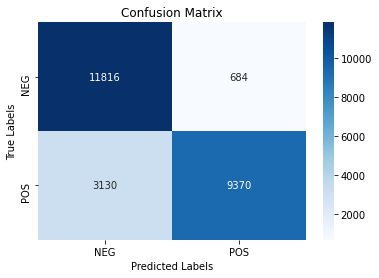

In [44]:
## Evaluate the model trained using progressive shrinking.
array = np.zeros((8,8))
for i in range(5,13):
    best_model = BERT().to(device)
    print("loading model trained with " + str(i) + " number of layers")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)
    for j in range(5,13):
        acc = evaluate(best_model, test_iter, max_encoder_num=j)
        array[i-5][j-5] = acc
        print("accuracy when using ", j, " layers : ", acc)
    print("results of the model trained using ",i," layers ")
    for j in range(5,13):
        print(j, " -> ", array[i-5][j-5])

In [40]:
acc

0.81848

In [45]:
array

array([[0.81848, 0.83168, 0.82952, 0.82248, 0.79808, 0.78276, 0.77948,
        0.77752],
       [0.6316 , 0.814  , 0.82156, 0.82484, 0.80056, 0.77772, 0.77052,
        0.76716],
       [0.60328, 0.79308, 0.84108, 0.84608, 0.82376, 0.80148, 0.79168,
        0.78688],
       [0.7458 , 0.70772, 0.76252, 0.85704, 0.86644, 0.85912, 0.85404,
        0.85304],
       [0.61312, 0.69984, 0.74272, 0.7998 , 0.83012, 0.8358 , 0.8344 ,
        0.8352 ],
       [0.54632, 0.6416 , 0.60428, 0.54592, 0.77792, 0.86832, 0.87336,
        0.87504],
       [0.61876, 0.70208, 0.7046 , 0.68356, 0.78936, 0.86356, 0.85972,
        0.85572],
       [0.50288, 0.5118 , 0.5168 , 0.54812, 0.59428, 0.68368, 0.75536,
        0.84744]])

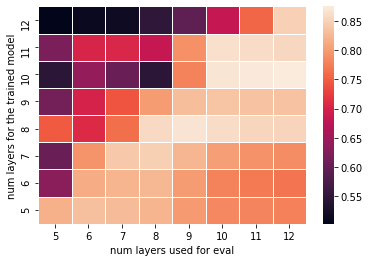

In [46]:
ax = sns.heatmap(array,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_xlabel('num layers used for eval')
ax.set_ylabel('num layers for the trained model')
# ax.axis([5, 12,5,12])
plt.show()

## Train using random number of layers.

In [52]:
# random.randint(5,12)
# train using randomly selected layers

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
print("Training model with random elasticity for 8 epochs.")
train(model=model, optimizer=optimizer, num_epochs = 8, random_elasticity=True)



initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model with random elasticity for 8 epochs.
/home/ilee300/workspace/nlp_ofa/notebooks/../model/Nonemetrics.pt
changing encoder number :  12  =>  10
training for epoch  0  with encoder number of  10
Epoch [1/8], Step [625/10000], Train Loss: 0.3570, Valid Loss: 0.3428
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/random_elasticity_model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../modelrandom_elasticity_metrics.pt
Epoch [1/8], Step [1250/10000], Train Loss: 0.3962, Valid Loss: 0.3330
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/random_elasticity_model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../modelrandom_elasticity_metrics.pt
changing encoder number :  12  =>  5
training for epoch  1  with encoder number of  5
Epoch [2/8], Step [1875/10000], Train Loss: 0.3259, Valid Loss: 0.4095
Epoch [2/8], Step [2500/10000], Train Loss: 0.3879, Valid Loss: 0.3645
changing encoder number :  12  =>  

loading the model trained with random elasticity
initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/random_elasticity_model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.6485    0.7359    0.6895     12500
           0     0.6948    0.6011    0.6446     12500

    accuracy                         0.6685     25000
   macro avg     0.6716    0.6685    0.6670     25000
weighted avg     0.6716    0.6685    0.6670     25000

accuracy when using  5  layers :  0.66852
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.8901    0.2979    0.4464     12500
           0     0.5784    0.9632    0.7228     12500

    accuracy                         0.6306     25000
   macro avg     0.7342    0.6306    0.5846     25000
weighted avg     0.7342    0.6306    0.5846     25000

ac

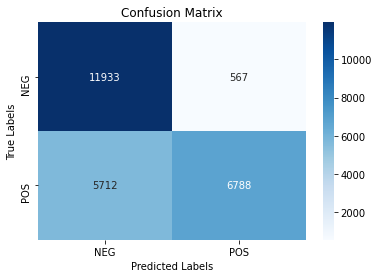

In [54]:
print("loading the model trained with random elasticity")
best_model = BERT().to(device)
load_checkpoint(destination_folder +'/random_elasticity_model.pt', best_model)
random_elasticity_accuracy_list = []
for i in range(5,13):
    acc = evaluate(best_model, test_iter, max_encoder_num=i)
    print("accuracy when using ", i, " layers : ", acc)
    random_elasticity_accuracy_list.append(acc)


In [55]:
random_elasticity_accuracy_list

[0.66852, 0.63056, 0.73856, 0.73156, 0.82168, 0.85408, 0.85456, 0.74884]

Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../modelrandom_elasticity_metrics.pt


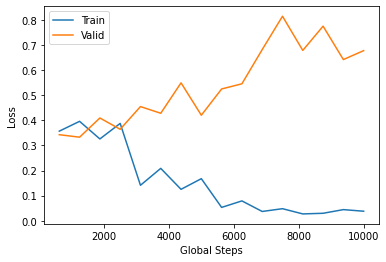

In [58]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder +'random_elasticity_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 